Kornpob Bhirombhakdi, kbhirombhakdi@stsci.edu

# Story
We would like to remove X01 contamination from GRB190829A. To achieve this, we developed hstgrism.contamination.Contamination class (see 20200828). We continue to finalize the code.

# Previously
Contamination class with HSTGRISM takes i) trace.csv of Object, ii) trace.csv of Contaminate, iii) halfdy of Object's extraction aperture, and iv) instrument provided by hstgrism.grismapcorr.GrismApCorr().table, and outputs contaminationTrace.csv which provides information of the Contaminate with respect to the Object. With contaminationTrace.csv, by providing Contaminate's spectral profile, one can quantitatively compute cps of Contaminate inside the Object's aperture. Therefore, one can remove this contamnination. In 20200828/01, we demonstrated how to use contaminationTrace.csv as mentioned in the 'New chunk' section. (Note also that we forgot to divide by 2 for the Contaminate cps since this is one-sided contamination).

# Task
At 20200828/01 summary, these following tasks should be done:
- We would like to wrap the last chunck with a wrapper. (Make sure to divide by 2. for one-side contamination).
 - Let's assume that the Object's aperture would always be on one side of Contaminate, to avoid complicating the code.
 - Let's also assume that the wrapper starts with Contaminate spectral profile providing wavelength and flam. With that, we will work backward from flam to cps, then connect to contaminateTrace.csv.


In [1]:
from astropy.io import fits
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

contaminateTrace_csv = '../20200828/01_outputs/01_outputs_contaminateTrace.csv'
x01_flam_csv = '../20200826/X01_together_G102/X01_together_G102.csv'
sensitivity_fits = '/Users/kbhirombhakdi/_work/_calib_files/WFC3.IR.G102.cal.V4.32/WFC3.IR.G102.1st.sens.2.fits'
# Note: use halfdy = 5 for GRB extraction
drz_apcorr_csv = '/Users/kbhirombhakdi/_work/GRB190829A/04_drzblot_crclean_apcorr/drzblot_S01_201909_G102/drzblot_S01_201909_G102_halfdy5_apcorr.csv'
grb_flam_csv = '/Users/kbhirombhakdi/_work/GRB190829A/05_flam_with_drzblot_correction/drzblot_GRB190829A_201909_G102-rerun/drzblot_GRB190829A_201909_G102-rerun-rerun_flam.csv'
##### read these files #####
contaminateTrace_df = pd.read_csv(contaminateTrace_csv)
x01_flam_ww = pd.read_csv(x01_flam_csv).ww.values
x01_flam_flam = pd.read_csv(x01_flam_csv).flam_smooth.values
fmodel = interp1d(x01_flam_ww,x01_flam_flam,kind='linear',bounds_error=False,fill_value=np.nan)
sensitivity_ww = fits.open(sensitivity_fits)[1].data.WAVELENGTH
sensitivity_sens = fits.open(sensitivity_fits)[1].data.SENSITIVITY
smodel = interp1d(sensitivity_ww,sensitivity_sens,kind='linear',bounds_error=False,fill_value=0.)
drz_apcorr = pd.read_csv(drz_apcorr_csv)
window_length = 21
polyorder = 1
tx = drz_apcorr.ww.values.copy()
ty = drz_apcorr.apcorr.values.copy()
tyy = savgol_filter(ty,window_length=window_length,polyorder=polyorder)
dapcorr_model = interp1d(tx,tyy,kind='nearest',bounds_error=False,fill_value='extrapolate')
grb_flam = pd.read_csv(grb_flam_csv)


In [128]:
##### wwperpix #####
xhdiff = np.diff(contaminateTrace_df.xg_object.values)
xhdiff = np.append(xhdiff,xhdiff[-1]) # add one last element to maintain the array dimension
wwdiff = np.diff(contaminateTrace_df.ww_contaminate.values)
wwdiff = np.append(wwdiff,wwdiff[-1]) # add one last element to maintain the array dimension
wwperpix = wwdiff/xhdiff
##### sens #####
sens = smodel(contaminateTrace_df.ww_contaminate.values)
##### flam projecting to GRB frame #####
flam = fmodel(contaminateTrace_df.ww_contaminate.values)
##### dapcorr #####
dapcorr = dapcorr_model(contaminateTrace_df.ww_contaminate.values)
##### apcorr #####
apcorr = np.full_like(wwperpix,1.,dtype=float) # keep this 1., because we want total cps.
##### cps #####
cps = flam * sens * wwperpix * dapcorr * apcorr
# Note we need to fix for negative and non-smooth cps.
# from visual examination, index [125,128] inclusive of cps needs to be set to 0.
cps_fix = cps.copy()
cps_fix[125:129] = 0.
# scale cps of Contaminate by apcorr_contaminate_in and out
# divide by 2 for one-side
cps_contaminate = 0.5 * cps_fix * (contaminateTrace_df.apcorr_contaminate_out.values - contaminateTrace_df.apcorr_contaminate_in.values)
# fix nan to zero
m = np.argwhere(~np.isfinite(cps_contaminate)).flatten()
cps_contaminate[m] = 0.
##### show #####
xg = contaminateTrace_df.xg_object.values
ww = contaminateTrace_df.ww_contaminate.values
df = {'xg':xg,'ww':ww,'xhdiff':xhdiff,'wwdiff':wwdiff,'wwperpix':wwperpix,'sens':sens,'flam':flam,'dapcorr':dapcorr,'apcorr':apcorr,'cps':cps,'cps_fix':cps_fix,'cps_contaminate':cps_contaminate}
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(pd.DataFrame(df))


      xg           ww  xhdiff     wwdiff   wwperpix          sens  \
0    539          NaN       1        NaN        NaN           NaN   
1    540          NaN       1        NaN        NaN           NaN   
2    541          NaN       1        NaN        NaN           NaN   
3    542          NaN       1        NaN        NaN           NaN   
4    543          NaN       1        NaN        NaN           NaN   
5    544          NaN       1        NaN        NaN           NaN   
6    545          NaN       1        NaN        NaN           NaN   
7    546          NaN       1        NaN        NaN           NaN   
8    547          NaN       1        NaN        NaN           NaN   
9    548          NaN       1        NaN        NaN           NaN   
10   549          NaN       1        NaN        NaN           NaN   
11   550          NaN       1        NaN        NaN           NaN   
12   551          NaN       1        NaN        NaN           NaN   
13   552          NaN       1     

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


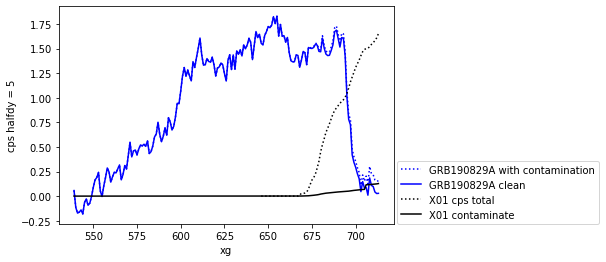

In [129]:
tx = contaminateTrace_df.xg_object.values
ty = grb_flam.cps.values
plt.plot(tx,ty,'b:',label='GRB190829A with contamination')
plt.plot(tx,ty - df['cps_contaminate'],'b-',label='GRB190829A clean')
plt.plot(tx,df['cps_fix'],'k:',label='X01 cps total')
plt.plot(tx,df['cps_contaminate'],'k-',label='X01 contaminate')
plt.xlabel('xg')
plt.ylabel('cps halfdy = 5')
plt.legend(loc=[1.01,0.])


In [136]:
from hstgrism.container import Container
sfolder = 'test'
cobj = Container(sfolder,sfolder,'pdf',False)


In [137]:
# update grb cps
t = grb_flam.copy()
t['cps_clean'] = grb_flam.cps.values - df['cps_contaminate']
string = './{0}/{1}_cpsclean.csv'.format(cobj.data['savefolder'],cobj.data['saveprefix'])
pd.DataFrame(t).to_csv(string)
print('Save {0}'.format(string))


Save ./test/test_cpsclean.csv


# Summary
This Notebook showed the steps from contaminateTrace.csv to Object clean of contamination.
- Input: contaminateTrace.csv, Contaminate spectrum, sensitivity of observing grism, drzblot_apcorr
 - This can provide Contaminate cps inside Object aperture.
 - drzblot_apcorr is needed if Object frame is drzblot. Note, drzblot_apcorr must have the same halfdy as extraction aperture.
- If Object cps (only inside the aperture, not calibrated to total cps) is provided, we can compute cps_clean as shown above.

May be, the best way to go with this wrapper is to extend Contamination class  in its compute(). Add another switch that can compute cps_contaminate given Contaminate spectrum and sensitivity. Outpus would be cps_contaminate appended as another column in contaminateTrace.csv.

Given this approach, a user can:
- make an Object run with regular HSTGRISM reduction flow. This will give cps inside the defined halfdy. 
 - If using flam.csv, use 'cps' column.
- make Contamination run using outputs from the Object run to get contaminateTrace.csv, of which trace runs parallel to Object trace. Use 'cps_contaminate' to subtract out from 'cps'. Then, calibrate from cps to flam.

# Bug found!!!
In GRB190829A/05/*, we did not apply drzblot_apcorr to get flam.
